In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import os

# 1. Carga y exploración de datos

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Datos de test:          {x_test.shape}")
print(f"Etiquetas train:        {y_train.shape}")
print(f"Etiquetas test:         {y_test.shape}")
print(f"\nPrimeras 10 etiquetas:  {y_train[:10]}")
print(f"Rango original:         [{x_train[0].min()}, {x_train[0].max()}]")

Datos de entrenamiento: (60000, 28, 28)
Datos de test:          (10000, 28, 28)
Etiquetas train:        (60000,)
Etiquetas test:         (10000,)

Primeras 10 etiquetas:  [5 0 4 1 9 2 1 3 1 4]
Rango original:         [0, 255]


# 2. Preprocesamiento

In [25]:
# Normalización
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"Rango normalizado: [{x_train[0].min():.2f}, {x_train[0].max():.2f}]")

Rango normalizado: [0.00, 1.00]


# 3. Configuraciones a evaluar

In [26]:
configurations = [
    {
        'name': 'SGD',
        'layers': [128],
        'optimizer': 'sgd',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'SGD_two_layers',
        'layers': [256, 128],
        'optimizer': 'sgd',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'Adagrad',
        'layers': [128],
        'optimizer': 'adagrad',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'Adagrad_two_layers',
        'layers': [256, 128],
        'optimizer': 'adagrad',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'RMSprop',
        'layers': [128],
        'optimizer': 'rmsprop',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'RMSprop_two_layers',
        'layers': [256, 128],
        'optimizer': 'rmsprop',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'Adam',
        'layers': [128],
        'optimizer': 'adam',
        'lr': 0.01,
        'batch_size': 128
    },
    {
        'name': 'Adam_two_layers',
        'layers': [256, 128],
        'optimizer': 'adam',
        'lr': 0.01,
        'batch_size': 128
    },
]

# 4. Función para crear modelos

In [27]:


def create_model(layers=[128]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    for neurons in layers:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return model

# 5. Función de evaluación completa

In [28]:


def evaluate_model(model: tf.keras.models.Sequential, x_test: np.ndarray, y_test: np.ndarray) -> dict:
    results = {}

    # Accuracy y loss en test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Predicciones y número de errores
    y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)

    errors = np.sum(y_pred != y_test)

    print(f"Errors:  {errors}/{len(y_test)} ({errors/len(y_test)*100:.2f}%)")

    # Matrices de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Guardar resultados
    results['loss'] = loss
    results['accuracy'] = accuracy
    results['errors'] = errors
    results['cm'] = cm
    results['predictions'] = y_pred

    return results

# 6. Entrenamiento de todas las configuraciones

In [29]:
epochs = 10
all_results = {}
all_histories = {}

for config in configurations:
    name = config['name']
    print(f"\n{'▶'*3} Configuración: {name}")
    print(f"    Capas: {config['layers']}")
    print(f"    Optimizer: {config['optimizer']} (lr={config['lr']})")
    print(f"    Batch size: {config['batch_size']}")

    # Crear modelo
    model = create_model(layers=config['layers'])

    # Compilar con configuración específica
    if config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=config['lr'])
    elif config['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=config['lr'])
    elif config['optimizer'] == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=config['lr'])

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar y medir tiempo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=config['batch_size'],
        validation_split=0.1,
        verbose=1
    )
    elapsed_time = time.time() - start_time

    print(f"\n⏱️  Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

    # Evaluar modelo
    results = evaluate_model(model, x_test, y_test)
    results['training_time'] = elapsed_time
    results['config'] = config

    # Guardar
    all_results[name] = results
    all_histories[name] = history


▶▶▶ Configuración: SGD
    Capas: [128]
    Optimizer: sgd (lr=0.01)
    Batch size: 128


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6940 - loss: 1.2574 - val_accuracy: 0.8683 - val_loss: 0.6604
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8540 - loss: 0.6015 - val_accuracy: 0.8968 - val_loss: 0.4350
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8786 - loss: 0.4685 - val_accuracy: 0.9098 - val_loss: 0.3590
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8907 - loss: 0.4108 - val_accuracy: 0.9178 - val_loss: 0.3218
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8976 - loss: 0.3773 - val_accuracy: 0.9215 - val_loss: 0.2979
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9025 - loss: 0.3544 - val_accuracy: 0.9248 - val_loss: 0.2814
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9071 - loss: 0.3370 - val_accuracy: 0.9288 - val_loss: 0.2690
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9101 - loss: 0.3230 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7273 - loss: 1.1953 - val_accuracy: 0.8887 - val_loss: 0.5262
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8754 - loss: 0.4884 - val_accuracy: 0.9145 - val_loss: 0.3440
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8944 - loss: 0.3848 - val_accuracy: 0.9233 - val_loss: 0.2918
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9042 - loss: 0.3407 - val_accuracy: 0.9277 - val_loss: 0.2647
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9122 - loss: 0.3129 - val_accuracy: 0.9323 - val_loss: 0.2474
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9172 - loss: 0.2925 - val_accuracy: 0.9373 - val_loss: 0.2346
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9217 - loss: 0.2759 - val_accuracy: 0.9390 - val_loss: 0.2202
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9257 - loss: 0.2620 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8130 - loss: 0.7552 - val_accuracy: 0.9093 - val_loss: 0.3592
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8959 - loss: 0.3834 - val_accuracy: 0.9273 - val_loss: 0.2828
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9093 - loss: 0.3278 - val_accuracy: 0.9338 - val_loss: 0.2509
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9174 - loss: 0.2970 - val_accuracy: 0.9375 - val_loss: 0.2335
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9233 - loss: 0.2752 - val_accuracy: 0.9410 - val_loss: 0.2181
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9282 - loss: 0.2579 - val_accuracy: 0.9440 - val_loss: 0.2062
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9319 - loss: 0.2435 - val_accuracy: 0.9495 - val_loss: 0.1958
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9358 - loss: 0.2313 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8199 - loss: 0.6988 - val_accuracy: 0.9207 - val_loss: 0.3012
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9085 - loss: 0.3229 - val_accuracy: 0.9342 - val_loss: 0.2376
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9242 - loss: 0.2679 - val_accuracy: 0.9433 - val_loss: 0.2064
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9336 - loss: 0.2339 - val_accuracy: 0.9507 - val_loss: 0.1824
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9406 - loss: 0.2086 - val_accuracy: 0.9552 - val_loss: 0.1649
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9464 - loss: 0.1887 - val_accuracy: 0.9602 - val_loss: 0.1509
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9516 - loss: 0.1727 - val_accuracy: 0.9623 - val_loss: 0.1410
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9550 - loss: 0.1594 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9174 - loss: 0.2860 - val_accuracy: 0.9647 - val_loss: 0.1192
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9642 - loss: 0.1244 - val_accuracy: 0.9685 - val_loss: 0.1186
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.0988 - val_accuracy: 0.9707 - val_loss: 0.1330
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9768 - loss: 0.0847 - val_accuracy: 0.9712 - val_loss: 0.1390
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.0719 - val_accuracy: 0.9705 - val_loss: 0.1485
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0650 - val_accuracy: 0.9733 - val_loss: 0.1428
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9852 - loss: 0.0560 - val_accuracy: 0.9763 - val_loss: 0.1526
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9867 - loss: 0.0502 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9001 - loss: 0.3705 - val_accuracy: 0.9680 - val_loss: 0.1138
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9595 - loss: 0.1482 - val_accuracy: 0.9615 - val_loss: 0.1534
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9669 - loss: 0.1265 - val_accuracy: 0.9668 - val_loss: 0.1329
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9709 - loss: 0.1154 - val_accuracy: 0.9578 - val_loss: 0.2356
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9745 - loss: 0.1073 - val_accuracy: 0.9747 - val_loss: 0.1415
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9763 - loss: 0.0995 - val_accuracy: 0.9728 - val_loss: 0.1708
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9774 - loss: 0.0999 - val_accuracy: 0.9662 - val_loss: 0.1961
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9791 - loss: 0.0981 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9295 - loss: 0.2317 - val_accuracy: 0.9672 - val_loss: 0.1110
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9654 - loss: 0.1159 - val_accuracy: 0.9725 - val_loss: 0.0914
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9737 - loss: 0.0860 - val_accuracy: 0.9650 - val_loss: 0.1245
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9762 - loss: 0.0765 - val_accuracy: 0.9712 - val_loss: 0.1062
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9789 - loss: 0.0697 - val_accuracy: 0.9680 - val_loss: 0.1142
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0621 - val_accuracy: 0.9705 - val_loss: 0.1151
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9818 - loss: 0.0616 - val_accuracy: 0.9695 - val_loss: 0.1207
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9831 - loss: 0.0580 - val_accuracy: 0.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9275 - loss: 0.2373 - val_accuracy: 0.9652 - val_loss: 0.1242
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9639 - loss: 0.1202 - val_accuracy: 0.9680 - val_loss: 0.1060
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9706 - loss: 0.1008 - val_accuracy: 0.9718 - val_loss: 0.1047
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9726 - loss: 0.0937 - val_accuracy: 0.9672 - val_loss: 0.1358
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9762 - loss: 0.0805 - val_accuracy: 0.9735 - val_loss: 0.1078
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9772 - loss: 0.0795 - val_accuracy: 0.9718 - val_loss: 0.1325
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9787 - loss: 0.0757 - val_accuracy: 0.9708 - val_loss: 0.1329
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9814 - loss: 0.0626 - val_accuracy: 0.

# 7. Tabla comparativa de resultados

In [30]:

comparison_data = []
for name, results in all_results.items():
    comparison_data.append({
        'Configuración': name,
        'Optimizer': results['config']['optimizer'],
        'LR': results['config']['lr'],
        'Batch Size': results['config']['batch_size'],
        'Capas': str(results['config']['layers']),
        'Test Acc': f"{results['accuracy']:.4f}",
        'Test Loss': f"{results['loss']:.4f}",
        'Test Errors': results['errors'],
        'Tiempo (s)': f"{results['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Guardar a CSV
os.makedirs('results', exist_ok=True)
df_comparison.to_csv('results/comparison_table.csv', index=False)
print("\n💾 Tabla guardada en: results/comparison_table.csv")

# Identificar mejor configuración
best_config = max(all_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 MEJOR CONFIGURACIÓN: {best_config[0]}")
print(f"   Test Accuracy: {best_config[1]['accuracy']:.4f}")
print(f"   Test Errors: {best_config[1]['errors']}")
print(f"   Training Time: {best_config[1]['training_time']:.2f}s")

     Configuración Optimizer   LR  Batch Size      Capas Test Acc Test Loss  Test Errors Tiempo (s)
               SGD       sgd 0.01         128      [128]   0.9236    0.2797          764      11.50
    SGD_two_layers       sgd 0.01         128 [256, 128]   0.9354    0.2262          646      18.77
           Adagrad   adagrad 0.01         128      [128]   0.9434    0.2016          566      13.21
Adagrad_two_layers   adagrad 0.01         128 [256, 128]   0.9603    0.1367          397      18.32
           RMSprop   rmsprop 0.01         128      [128]   0.9718    0.1946          282      13.64
RMSprop_two_layers   rmsprop 0.01         128 [256, 128]   0.9594    0.3920          406      19.65
              Adam      adam 0.01         128      [128]   0.9723    0.1489          277      13.75
   Adam_two_layers      adam 0.01         128 [256, 128]   0.9713    0.1362          287      20.65

💾 Tabla guardada en: results/comparison_table.csv

🏆 MEJOR CONFIGURACIÓN: Adam
   Test Accuracy: 0.

# 8. Visualizaciones comparativas

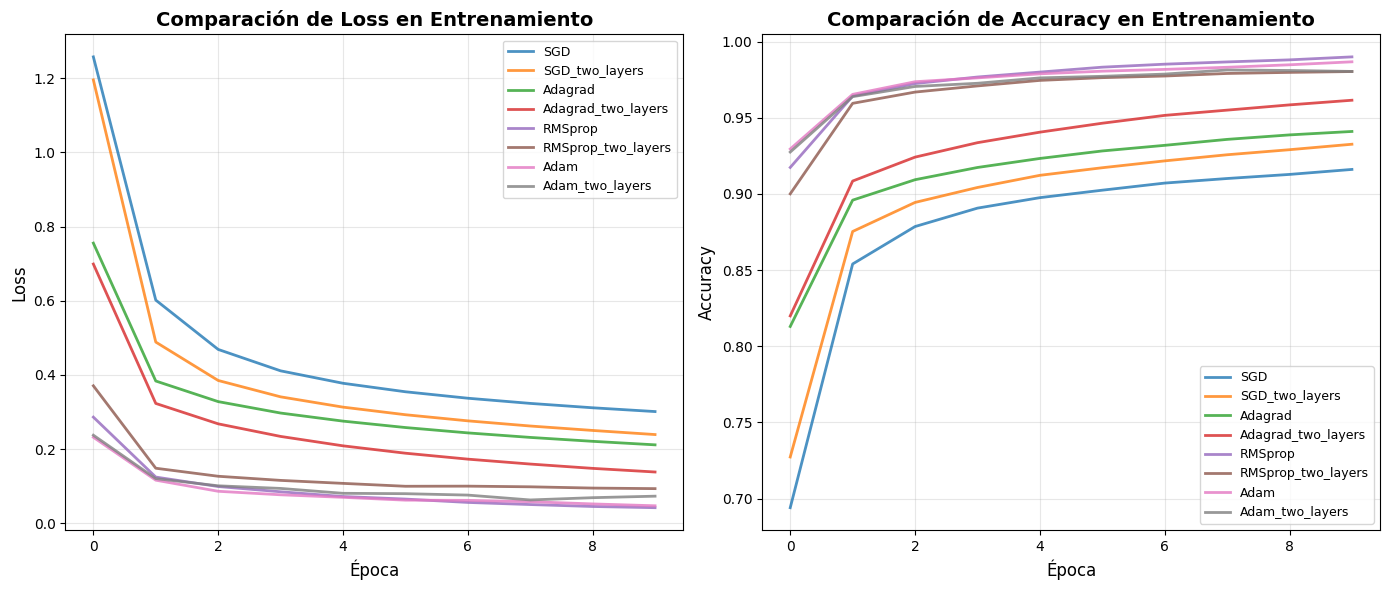

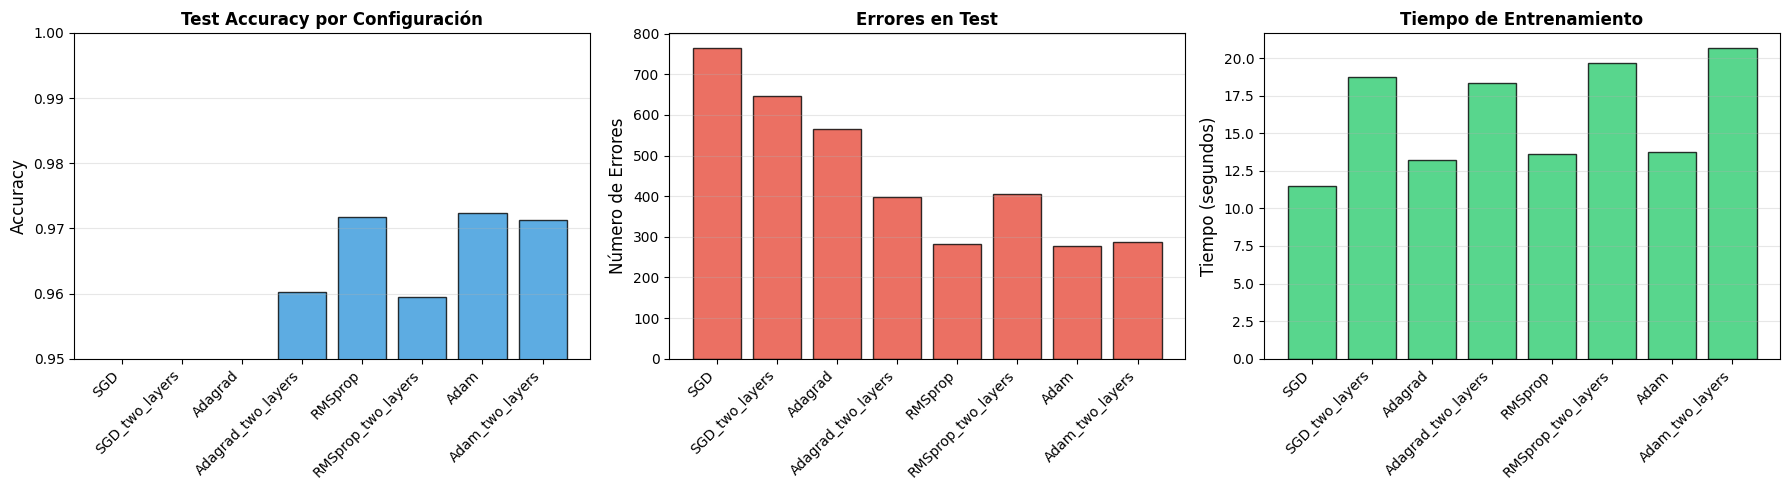

In [31]:
# Gráfica comparativa: Loss durante entrenamiento
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in all_histories.items():
    plt.plot(history.history['loss'], label=name, linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Comparación de Loss en Entrenamiento', fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for name, history in all_histories.items():
    plt.plot(history.history['accuracy'], label=name, linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparación de Accuracy en Entrenamiento', fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Gráfica de barras: Accuracy final
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test Accuracy
config_names = list(all_results.keys())
test_accs = [all_results[name]['accuracy'] for name in config_names]

axes[0].bar(range(len(config_names)), test_accs, color='#3498db', alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(config_names)))
axes[0].set_xticklabels(config_names, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy por Configuración', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.95, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Test Errors
test_errors = [all_results[name]['errors'] for name in config_names]
axes[1].bar(range(len(config_names)), test_errors, color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].set_xticks(range(len(config_names)))
axes[1].set_xticklabels(config_names, rotation=45, ha='right')
axes[1].set_ylabel('Número de Errores', fontsize=12)
axes[1].set_title('Errores en Test', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Training Time
train_times = [all_results[name]['training_time'] for name in config_names]
axes[2].bar(range(len(config_names)), train_times, color='#2ecc71', alpha=0.8, edgecolor='black')
axes[2].set_xticks(range(len(config_names)))
axes[2].set_xticklabels(config_names, rotation=45, ha='right')
axes[2].set_ylabel('Tiempo (segundos)', fontsize=12)
axes[2].set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 9. Matrices de confusión

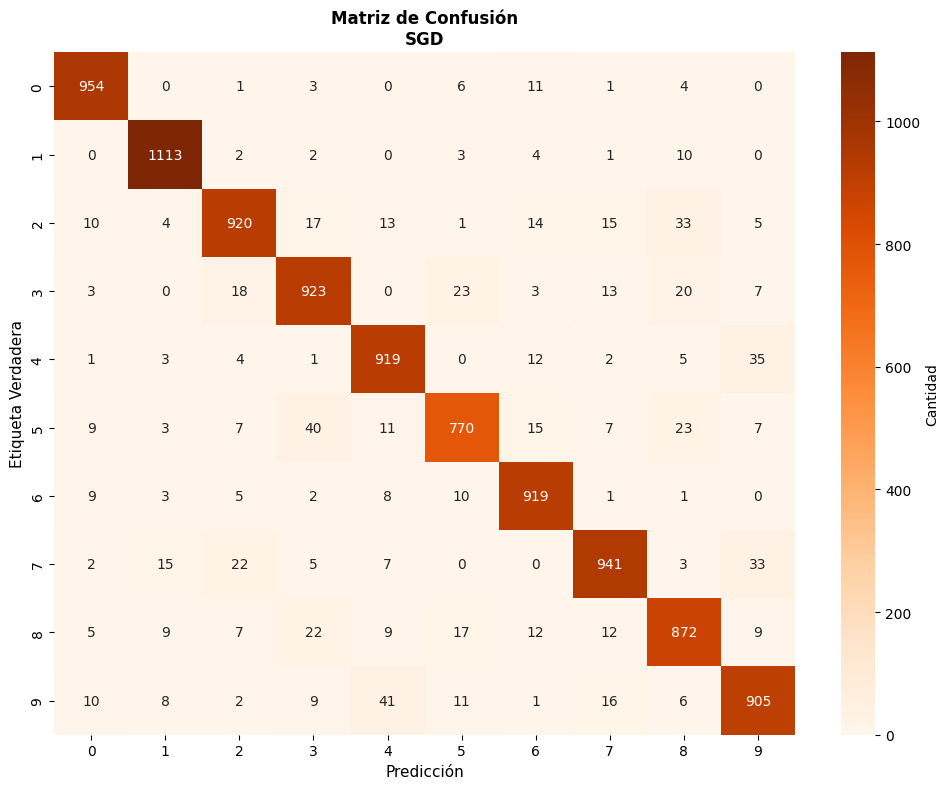

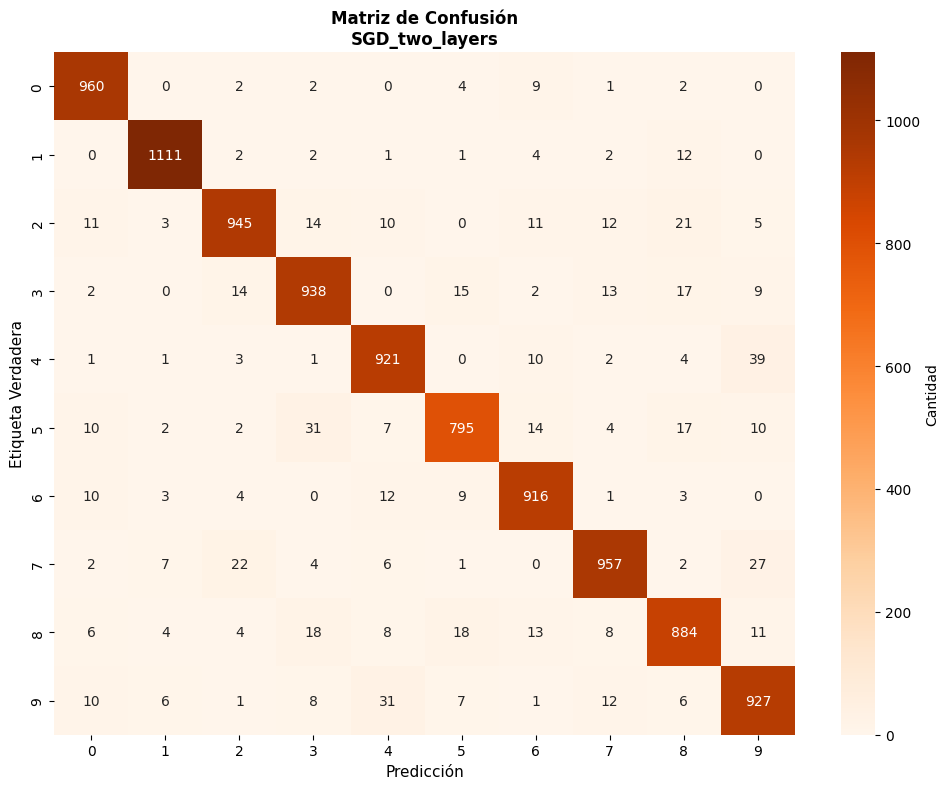

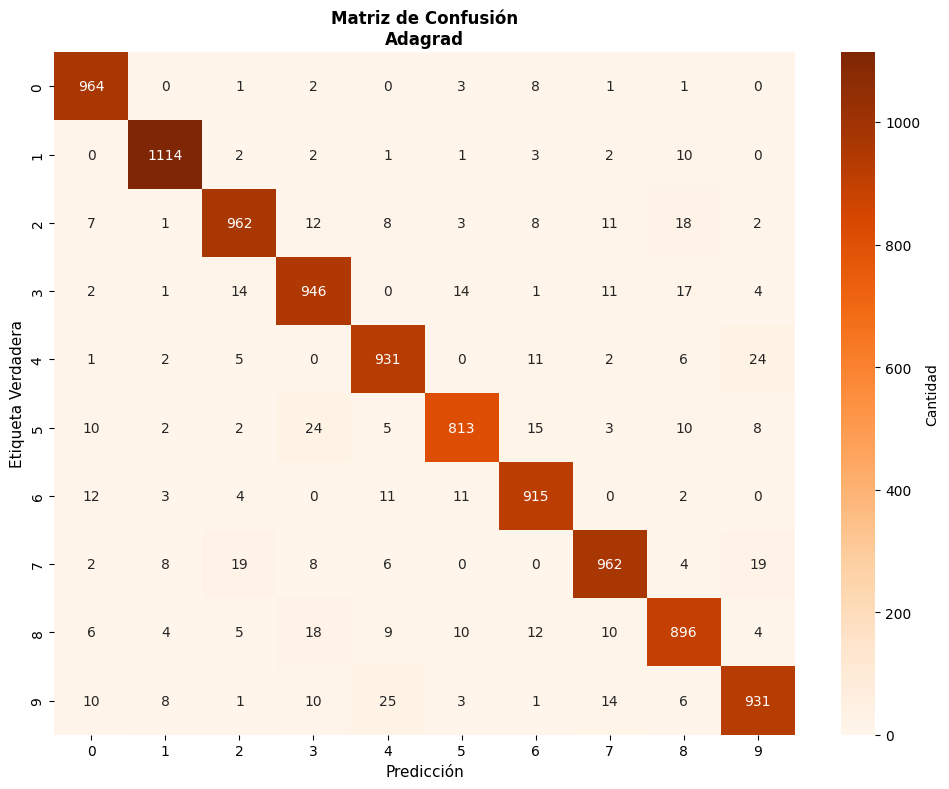

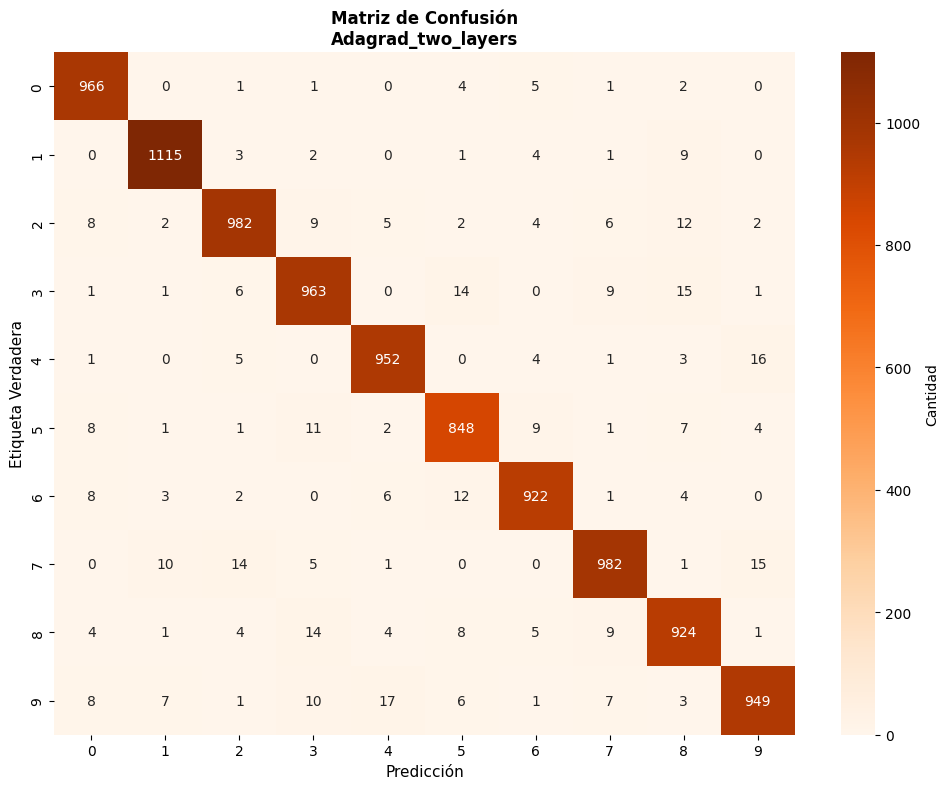

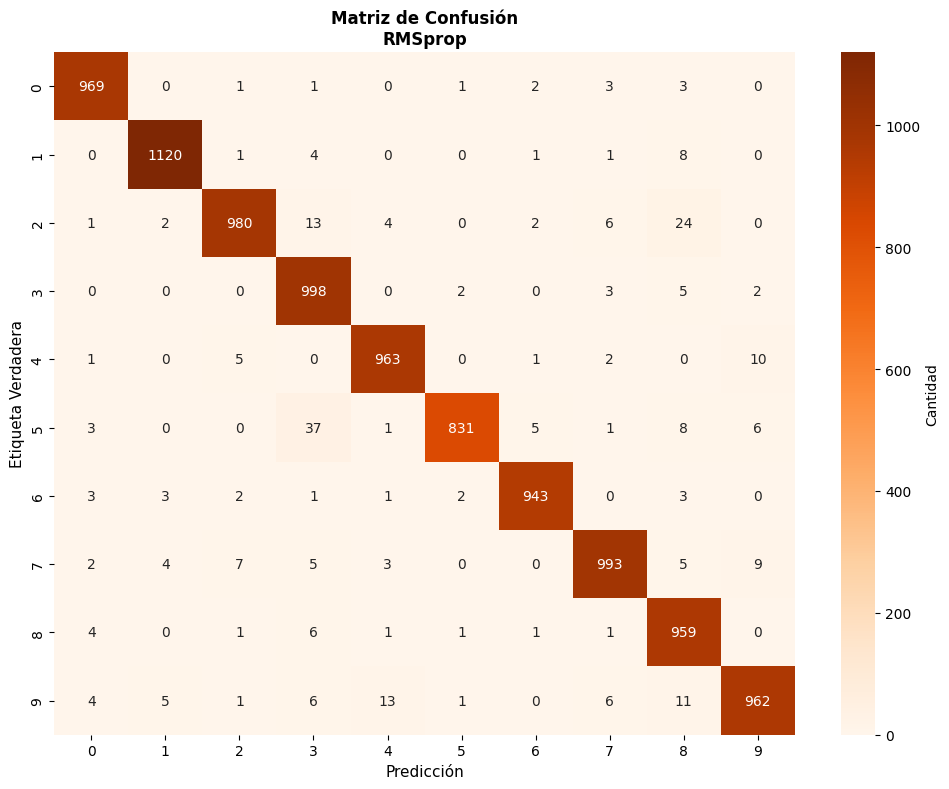

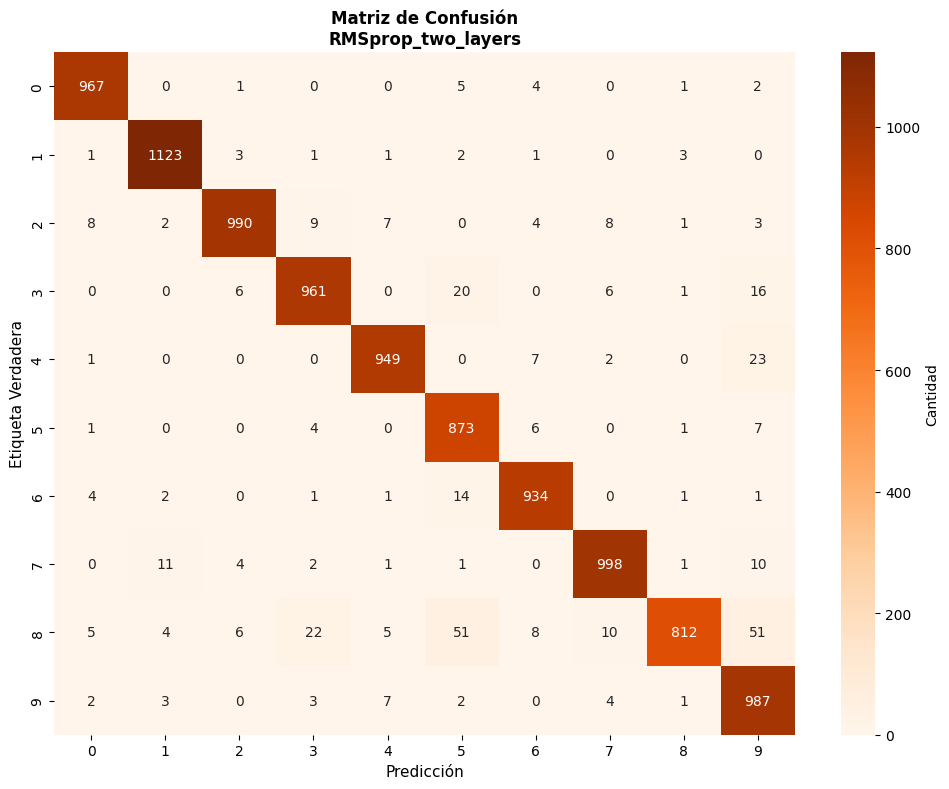

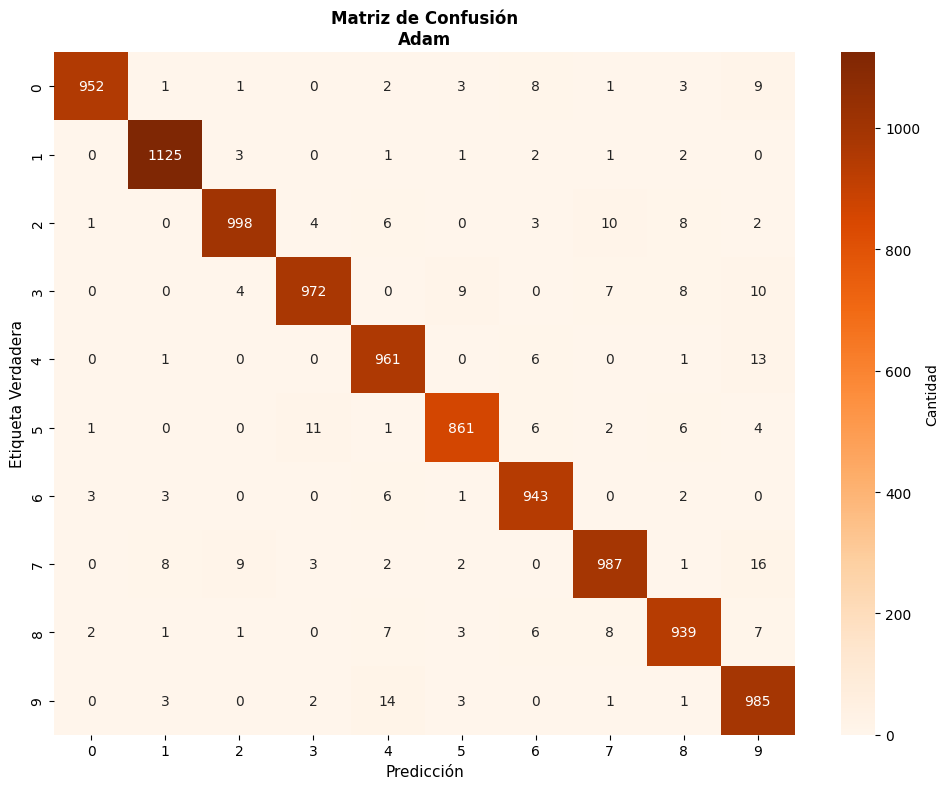

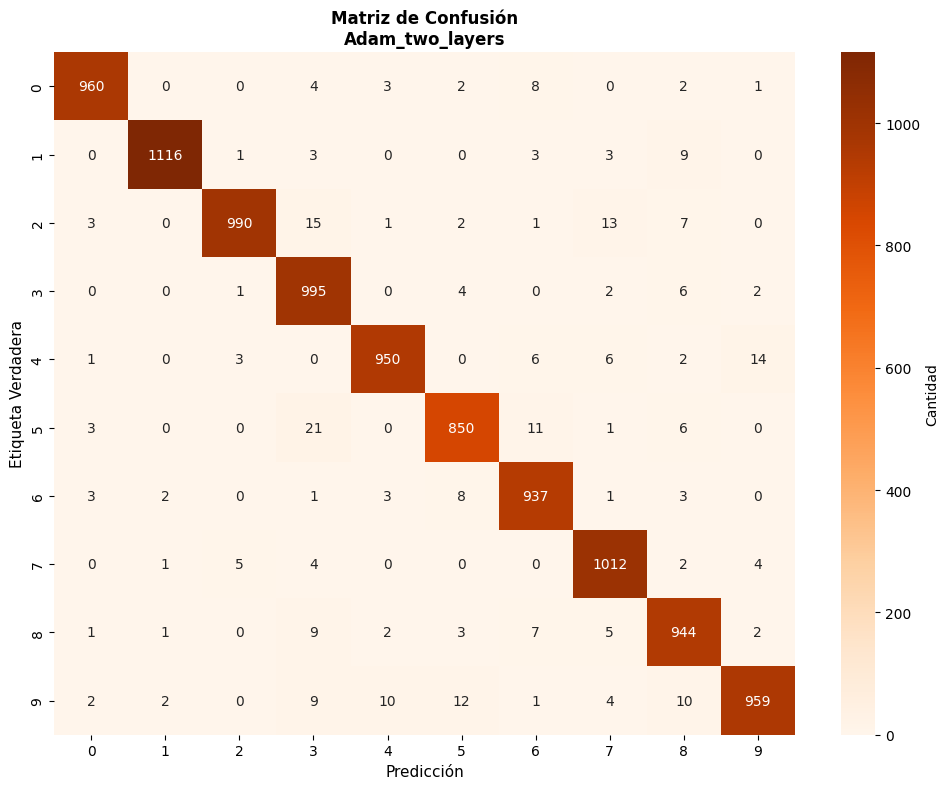

In [32]:
# Visualizar matrices de confusión para cada configuración
for name, results in all_results.items():
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Test confusion matrix
    sns.heatmap(results['cm'], annot=True, fmt='d', cmap='Oranges',
                ax=ax, cbar_kws={'label': 'Cantidad'})
    ax.set_xlabel('Predicción', fontsize=11)
    ax.set_ylabel('Etiqueta Verdadera', fontsize=11)
    ax.set_title(f'Matriz de Confusión\n{name}', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'results/confusion_matrix_{name}.png', dpi=150, bbox_inches='tight')
    plt.show()